In [7]:
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor 

In [3]:
# Download training data from open datasets.
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

6.9%

100.0%


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100.0%

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw




29.8%

100.0%


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100.0%

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



## Visualize the data

In [14]:
batch_size = 64
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle=True)

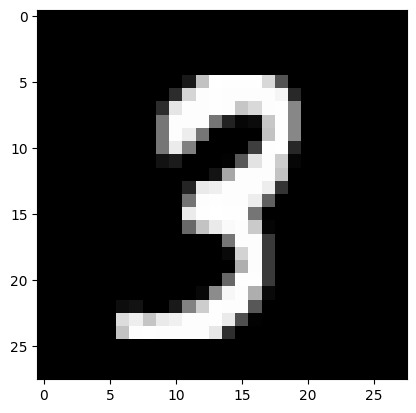

In [34]:
images, labels = next(iter(train_dataloader))

images.shape

plt.imshow(images[0].reshape(28,28), cmap="gray");